In [ ]:
!pip install biosppy

     |████████████████████████████████| 85 kB 3.4 MB/s 
  Created wheel for biosppy: filename=biosppy-0.7.3-py2.py3-none-any.whl size=95430 sha256=26a8a30340d6711be05ba0e636aab6404b7e540cd374a4d1ba6b60abc2e8c248
  Stored in directory: /root/.cache/pip/wheels/2f/4f/8f/28b2adc462d7e37245507324f4817ce1c64ef2464f099f4f0b
Successfully built biosppy


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import librosa
import itertools
import pickle
import cv2
import sklearn.preprocessing as skp
import torch.nn.functional as F
import random

from torch.cuda.amp import GradScaler
from torch.utils.data import DataLoader
from torch.autograd import Variable
from tqdm import tqdm
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from torchsummary import summary as summary
%matplotlib inline

In [ ]:
drive.mount('/gdrive',force_remount=True)

Mounted at /gdrive


In [ ]:
import numpy as np
from biosppy.signals import tools as tools

def filter_ecg(signal, sampling_rate):
    
    signal = np.array(signal)
    order = int(0.3 * sampling_rate)
    filtered, _, _ = tools.filter_signal(signal=signal,
                                  ftype='FIR',
                                  band='bandpass',
                                  order=order,
                                  frequency=[3, 45],
                                  sampling_rate=sampling_rate)
    
    return filtered

def filter_ppg(signal, sampling_rate):
    
    signal = np.array(signal)
    sampling_rate = float(sampling_rate)
    filtered, _, _ = tools.filter_signal(signal=signal,
                                  ftype='butter',
                                  band='bandpass',
                                  order=4, #3
                                  frequency=[1, 8], #[0.5, 8]
                                  sampling_rate=sampling_rate)

    return filtered

def load_data(ppg,ecg,ppg_sr,ecg_sr):
    
    ppg = np.array(ppg, dtype='float64')
    ecg = np.array(ecg, dtype = 'float64')
    #128HZ Resample
    ppg = ppg.reshape(-1)
    ecg = ecg.reshape(-1)
    ppg = librosa.resample(ppg, ppg_sr, 128)
    ecg = librosa.resample(ecg, ecg_sr, 128)
    
    ppg = filter_ppg(ppg, 128)
    ecg = filter_ecg(ecg, 128)
    
    #z normalization
    mean = ppg.mean()
    std = ppg.std()
    ppg -=mean
    ppg/=std

    mean = ecg.mean()
    std = ecg.std()
    ecg -=mean
    ecg/=std

    #segmentation 128 * 4sec overlap 10%
    i = 0

    while True:
      if i==0:
        s = 0
        e = 512
      else:
        s = 512 * i - 51
        e = 512 * (i+1) - 51
        if e > len(ecg):
          break;
      sampled_ecg = ecg[s:e]
      sampled_ppg = ppg[s:e]

      sampled_ecg = sampled_ecg.reshape(1,-1)
      sampled_ppg = sampled_ppg.reshape(1,-1)

      sampled_ecg = skp.minmax_scale(sampled_ecg,[-1,1],axis=1)
      sampled_ppg = skp.minmax_scale(sampled_ppg,[-1,1],axis=1)
      ecg_list.append(sampled_ecg)
      ppg_list.append(sampled_ppg)
      i+=1
    

In [ ]:
ecg_list = []
ppg_list = []

ecg_list = np.load('/gdrive/My Drive/model/ecg_list.npy')
ppg_list = np.load('/gdrive/My Drive/model/ppg_list.npy')

#BIDMC Dataset


In [ ]:
# for n in range(53):
#   data = pd.read_csv('/gdrive/My Drive/bidmc_csv/bidmc_%s_Signals.csv'%format(n+1,'02'))
#   ppg = data[' PLETH']
#   ecg = data[' II']

#   load_data(ppg,ecg,125,125)

#WESAD Dataset

In [ ]:
# for n in range(2,18):
#    if n==12:
#      continue
#    data = pickle.load(open('/gdrive/My Drive/WESAD/S%d/S%d.pkl'%(n,n),'rb'),encoding='latin1')
#    ecg = data['signal']['chest']['ECG']
#    ppg = data['signal']['wrist']['BVP']

#    load_data(ppg,ecg,64,700)

#DALIA Dataset

In [ ]:
# for n in range(1,16):
#    data = pickle.load(open('/gdrive/My Drive/PPG_FieldStudy/S%d/S%d.pkl'%(n,n),'rb'),encoding='latin1')
#    ecg = data['signal']['chest']['ECG']
#    ppg = data['signal']['wrist']['BVP']
  
#    load_data(ppg,ecg,64,700)

In [ ]:
ppg_list = np.array(ppg_list, dtype='float64')
ecg_list = np.array(ecg_list, dtype='float64')
print(ecg_list.shape, ppg_list.shape)

(60439, 1, 512) (60439, 1, 512)


In [ ]:
# np.save('/gdrive/My Drive/model/ecg_list.npy',ecg_list)
# np.save('/gdrive/My Drive/model/ppg_list.npy',ppg_list)

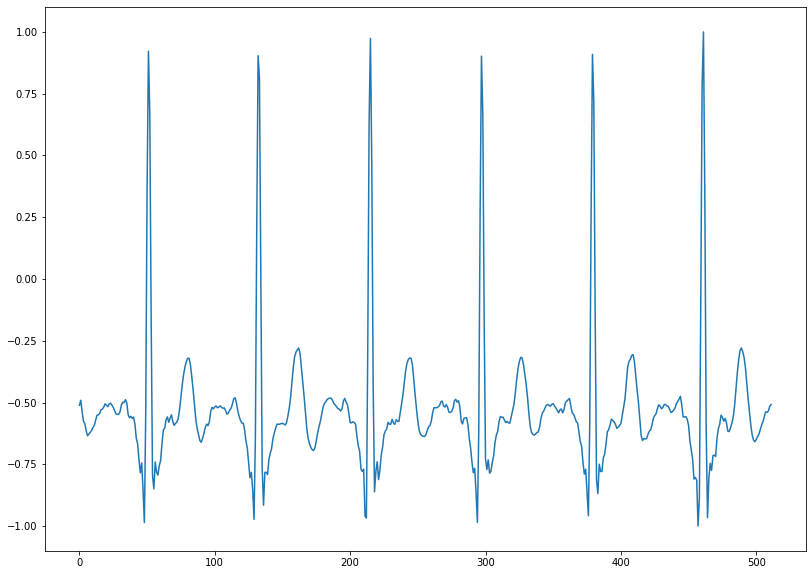

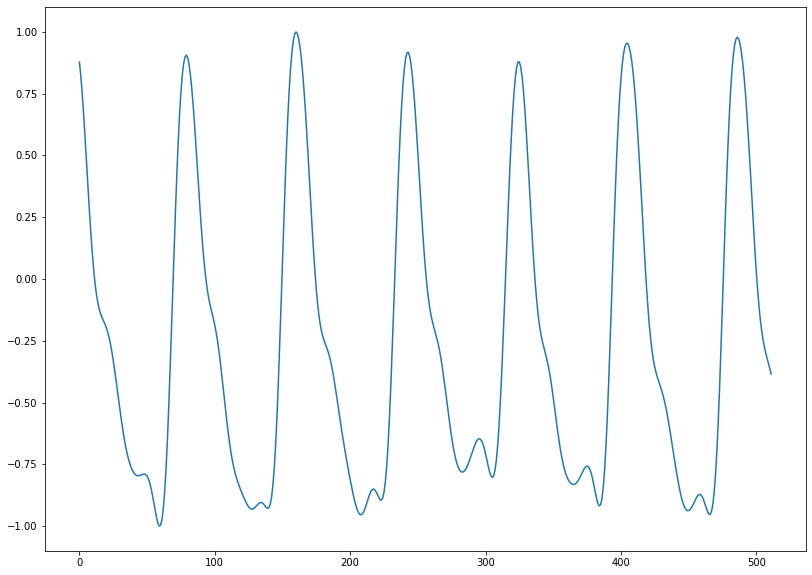

In [ ]:
plt.rcParams['figure.figsize'] = (30,10)
plt.subplot(1,2,1)
plt.plot(ecg_list[0,0,:])
plt.show()

plt.subplot(1,2,2)
plt.plot(ppg_list[1,0,:])
plt.show()

In [ ]:
class SignalDataSet(torch.utils.data.Dataset):
  def __init__(self, ppg_list, ecg_list):
    self.ppg_list = np.array(ppg_list)
    self.ecg_list = np.array(ecg_list)

  def __len__(self):
    return len(self.ppg_list)
  def __getitem__(self,index):
    return self.ppg_list[index], self.ecg_list[index]

In [ ]:
class ReplayBuffer():
    def __init__(self, max_size=50):
        assert (max_size > 0), 'Empty buffer or trying to create a black hole. Be careful.'
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0,1) > 0.5:
                    i = random.randint(0, self.max_size-1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return Variable(torch.cat(to_return))

In [ ]:
def Conv1d(in_channels, out_channels, kernel_size, padding=0, stride=1):
  layer = nn.Conv2d(in_channels, out_channels, kernel_size=(1,kernel_size), padding = (0,padding), stride=(1,stride) ,bias=False)
  nn.init.normal_(layer.weight.data,0.0,0.02)
  return layer

def DeConv1d(in_channels, out_channels, kernel_size, padding=0, stride=1):
  layer = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=(1,kernel_size), padding = (0, padding), stride=(1,stride),bias=False)
  nn.init.normal_(layer.weight.data,0.0,0.02)
  return layer

class AttentionBlock(nn.Module):
  def __init__(self, in_channels):
    super(AttentionBlock, self).__init__()
    self.layer_x = Conv1d(in_channels,1,1)
    self.layer_g = Conv1d(in_channels,1,1)
    self.out_layer = nn.Sequential(
        nn.ReLU(),
        Conv1d(1,1,1),
        nn.Sigmoid()
    )

  def forward(self,conn_out, curr_out):
    x = self.layer_x(conn_out)
    g = self.layer_g(curr_out)

    out = torch.add(x,g)
    out = self.out_layer(out)
    out = torch.mul(out,conn_out)

    return out

In [ ]:
def downsample(in_channels, out_channels, norm_dim=None, kernel_size = 16, stride=2):
  layer = []
  layer.append(Conv1d(in_channels, out_channels,kernel_size, padding=7,stride=stride))
  if norm_dim != None:
    layer.append(nn.LayerNorm(norm_dim))

  layer.append(nn.LeakyReLU(0.2))

  return nn.Sequential(*layer)

def upsample(in_channels, out_channels, norm_dim=None, padding=7,kernel_size=16,stride=2):
  layer = []
  layer.append(DeConv1d(in_channels, out_channels, kernel_size, padding=padding,stride=stride))
  if norm_dim != None:
    layer.append(nn.LayerNorm(norm_dim))
  layer.append(nn.ReLU())

  return nn.Sequential(*layer)

class Generator(nn.Module):
  def __init__(self):
    super(Generator,self).__init__()
    #down
    self.down_layer1 = downsample(1,64,None)
    self.down_layer2 = downsample(64,128,128)
    self.down_layer3 = downsample(128,256,64)
    self.down_layer4 = downsample(256,512,32)
    self.down_layer5 = downsample(512,512,16)
    self.down_layer6 = downsample(512,512,8)
    #attention
    self.attention_layer1 = AttentionBlock(512)
    self.attention_layer2 = AttentionBlock(512)
    self.attention_layer3 = AttentionBlock(512)
    self.attention_layer4 = AttentionBlock(256)
    self.attention_layer5 = AttentionBlock(128)
    self.attention_layer6 = AttentionBlock(64)
    #up
    self.up_layer1 = DeConv1d(512,512,16,8,1)
    self.up_layer1_norm = nn.Sequential(
        nn.LayerNorm(8),
        nn.ReLU()
    )
    self.up_layer2 = upsample(512,512,16)
    self.up_layer3 = upsample(512,512,32)
    self.up_layer4 = upsample(512,256,64)
    self.up_layer5 = upsample(256,128,128)
    self.up_layer6 = upsample(128,64,256)

    self.out_layer = nn.Sequential(
      DeConv1d(64,1,16,7,2),
      nn.Tanh()
    )

  def forward(self,x):
    connection = []
    out = x

    #down
    for i in range(6):
      layer_name = 'down_layer' + str(i+1)
      layer = getattr(self,layer_name)
      out = layer(out)
      connection.append(out)
   
    out = F.pad(out,(1,0))
    #up
    for i in range(6):
      layer_name = 'up_layer'+str(i+1)
      att_layer_name = 'attention_layer'+str(i+1)
      layer = getattr(self,layer_name)
      att_layer = getattr(self,att_layer_name)

      out = layer(out)
      if i==0:
        out = self.up_layer1_norm(out)

      att = att_layer(connection[5-i],out)
      out = torch.add(out,att)

    out = self.out_layer(out)

    return out

In [ ]:
class TimeDiscriminator(nn.Module):
  def __init__(self):
    super(TimeDiscriminator,self).__init__()
    self.layer1 = downsample(1,64,None)
    
    self.layer2 = downsample(64,128,128)
    self.layer3 = downsample(128,256,64)
    self.layer4 = downsample(256,512,32)
    self.out_layer = Conv1d(512,1,kernel_size=16,padding=7,stride=2)
    
  def forward(self,x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = self.out_layer(out)

    return out

In [ ]:
def stft(signal_list):
  signal_np = signal_list.cpu().detach()
  signal_np=np.array(signal_np, dtype='float64')
  freq_list = []
  
  for signal in signal_np:
    freq = librosa.stft(signal[0,0],n_fft=255,hop_length=4,center=True)
    freq = np.abs(freq)
    freq = np.log(freq+1e-10)
    freq_list.append(freq)

  freq_list = torch.cuda.DoubleTensor(np.array(freq_list, dtype='float64'))

  return freq_list 

In [ ]:
class FrequencyDiscriminator(nn.Module):
  def __init__(self):
    super(FrequencyDiscriminator, self).__init__()

    self.layer1 = nn.Sequential(
        nn.Conv2d(1,64,(7,7),stride=2,padding=3,bias=False),
        nn.LeakyReLU(0.2)
    )

    self.layer2 = nn.Sequential(
        nn.Conv2d(64,128,(7,7),stride=2,padding=3,bias=False),
        nn.LayerNorm(32),
        nn.LeakyReLU(0.2)
    )
    
    self.layer3 = nn.Sequential(
        nn.Conv2d(128,256,(7,7),stride=2,padding=3,bias=False),
        nn.LayerNorm(16),
        nn.LeakyReLU(0.2)
    )

    self.layer4 = nn.Sequential(
        nn.Conv2d(256,512,(7,7),stride=2,padding=3,bias=False),
        nn.LayerNorm(8),
        nn.LeakyReLU(0.2)
    )
    self.out_layer = nn.Sequential(
        nn.Conv2d(512,1,(7,7),stride=2,padding=3,bias=False),
        # nn.Sigmoid()
    )
    for m in self.modules():
      if isinstance(m,nn.Conv2d):
        nn.init.normal_(m.weight.data,0.0,0.02) 
               
  def forward(self,x):
    out = stft(x)
    out.unsqueeze_(1)
    
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = self.out_layer(out)

    return out

In [ ]:
train_ppg,test_ppg,train_ecg, test_ecg = train_test_split(ppg_list,ecg_list,test_size=0.1,random_state=42)
train_ppg = shuffle(train_ppg, random_state=41)
train_ecg = shuffle(train_ecg, random_state=40)


print(len(train_ppg))
print(len(test_ppg))

print(len(train_ppg) + len(test_ppg))

54395
6044
60439


In [ ]:
train_ppg[0].shape


(1, 512)

In [ ]:
train_data = SignalDataSet(ppg_list=train_ppg, ecg_list=train_ecg)
test_data = SignalDataSet(test_ppg,test_ecg)

train_loader = DataLoader(train_data,batch_size=128,drop_last=True,num_workers=4)
test_loader = DataLoader(test_data,batch_size=128,drop_last=True,num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


#Summary

In [ ]:
# ecg_generator = Generator().double().cuda()
# ecg_time_discriminator = TimeDiscriminator().double().cuda()
# ecg_freq_discriminator= FrequencyDiscriminator().double().cuda()

# ppg_generator = Generator().double().cuda()
# ppg_time_discriminator = TimeDiscriminator().double().cuda()
# ppg_freq_discriminator= FrequencyDiscriminator().double().cuda()

# ecg_fake_buffer = ReplayBuffer()
# ppg_fake_buffer = ReplayBuffer()

ecg_fake_buffer = torch.load('/gdrive/My Drive/model/ecg_fake_buffer2.pkl')
ppg_fake_buffer = torch.load('/gdrive/My Drive/model/ppg_fake_buffer2.pkl')
ppg_generator = torch.load('/gdrive/My Drive/model/ppg_generator2.pkl').cuda()
ecg_generator = torch.load('/gdrive/My Drive/model/ecg_generator2.pkl').cuda()

ecg_time_discriminator = torch.load('/gdrive/My Drive/model/ecg_time_discriminator2.pkl').cuda()
ecg_freq_discriminator = torch.load('/gdrive/My Drive/model/ecg_freq_discriminator2.pkl').cuda()
ppg_time_discriminator = torch.load('/gdrive/My Drive/model/ppg_time_discriminator2.pkl').cuda()
ppg_freq_discriminator = torch.load('/gdrive/My Drive/model/ppg_freq_discriminator2.pkl').cuda()

In [ ]:
learning_rate = 1e-4
gan_loss_func = nn.MSELoss()
cycle_loss_func = nn.L1Loss()


generator_optimizer = optim.Adam(itertools.chain(ecg_generator.parameters(), ppg_generator.parameters()),lr=learning_rate)
ppg_time_discriminator_optimizer = optim.Adam(ppg_time_discriminator.parameters(),lr=learning_rate)
ppg_freq_discriminator_optimizer = optim.Adam(ppg_freq_discriminator.parameters(),lr=learning_rate)
ecg_time_discriminator_optimizer = optim.Adam(ecg_time_discriminator.parameters(),lr=learning_rate)
ecg_freq_discriminator_optimizer = optim.Adam(ecg_freq_discriminator.parameters(),lr=learning_rate)

In [ ]:
def train(ppg,ecg ,a,b,r, train):
  ecg.unsqueeze_(1)
  ppg.unsqueeze_(1)

  ecg = Variable(ecg).cuda()
  ppg = Variable(ppg).cuda()

  ppg_generator.train()
  ppg_time_discriminator.train()
  ppg_freq_discriminator.train()

  ecg_generator.train()
  ecg_time_discriminator.train()
  ecg_freq_discriminator.train()

  #generator train
  generator_optimizer.zero_grad()
  
  fake_ecg = ecg_generator(ppg)
  fake_ppg = ppg_generator(ecg)
  cycle_ecg = ecg_generator(fake_ppg)
  cycle_ppg = ppg_generator(fake_ecg)

  ecg_time_disc = ecg_time_discriminator(fake_ecg)
  time_target_real = Variable(torch.cuda.DoubleTensor(*(ecg_time_disc.shape)).fill_(1.0), requires_grad=False)
  time_target_fake = Variable(torch.cuda.DoubleTensor(*(ecg_time_disc.shape)).fill_(0.0), requires_grad=False)
  ecg_time_gan_loss = gan_loss_func(ecg_time_disc, time_target_real)
  
  ecg_freq_disc = ecg_freq_discriminator(fake_ecg)
  freq_target_real = Variable(torch.cuda.DoubleTensor(*(ecg_freq_disc.shape)).fill_(1.0), requires_grad=False)
  freq_target_fake = Variable(torch.cuda.DoubleTensor(*(ecg_freq_disc.shape)).fill_(0.0), requires_grad=False)
  ecg_freq_gan_loss = gan_loss_func(ecg_freq_disc, freq_target_real)

  ppg_time_disc = ppg_time_discriminator(fake_ppg)
  ppg_time_gan_loss = gan_loss_func(ppg_time_disc, time_target_real)
  ppg_freq_disc = ppg_freq_discriminator(fake_ppg)
  ppg_freq_gan_loss = gan_loss_func(ppg_freq_disc, freq_target_real)
  
  ecg_cycle_loss = cycle_loss_func(cycle_ecg, ecg)
  ppg_cycle_loss = cycle_loss_func(cycle_ppg, ppg)

  gan_loss = (ecg_time_gan_loss + ppg_time_gan_loss) * a + (ecg_freq_gan_loss + ppg_freq_gan_loss) * b + (ecg_cycle_loss + ppg_cycle_loss) * r
  gan_loss.backward()
  generator_optimizer.step()

  #replay buffer
  fake_ecg = ecg_fake_buffer.push_and_pop(fake_ecg)
  fake_ppg = ppg_fake_buffer.push_and_pop(fake_ppg)

  #ecg time disc train
  ecg_time_discriminator.zero_grad()
  ecg_time_disc = ecg_time_discriminator(fake_ecg.detach())
  ecg_time_disc_loss = (gan_loss_func(ecg_time_disc,time_target_fake)+ gan_loss_func(ecg_time_discriminator(ecg),time_target_real)) * 0.5
  ecg_time_disc_loss.backward()
  ecg_time_discriminator_optimizer.step()
  

  #ecg freq disc train
  ecg_freq_discriminator.zero_grad()
  ecg_freq_disc = ecg_freq_discriminator(fake_ecg.detach())
  ecg_freq_disc_loss = (gan_loss_func(ecg_freq_disc,freq_target_fake)+ gan_loss_func(ecg_freq_discriminator(ecg),freq_target_real)) * 0.5
  ecg_freq_disc_loss.backward()
  ecg_freq_discriminator_optimizer.step()

  #ppg time disc train
  ppg_time_discriminator.zero_grad()
  ppg_time_disc = ppg_time_discriminator(fake_ppg.detach())
  ppg_time_disc_loss = (gan_loss_func(ppg_time_disc,time_target_fake)+ gan_loss_func(ppg_time_discriminator(ppg),time_target_real)) * 0.5
  ppg_time_disc_loss.backward()
  ppg_time_discriminator_optimizer.step()

  #ppg freq disc train
  ppg_freq_discriminator.zero_grad()
  ppg_freq_disc = ppg_freq_discriminator(fake_ppg.detach())
  ppg_freq_disc_loss = (gan_loss_func(ppg_freq_disc,freq_target_fake)+ gan_loss_func(ppg_freq_discriminator(ppg),freq_target_real)) * 0.5
  ppg_freq_disc_loss.backward()
  ppg_freq_discriminator_optimizer.step()

  return gan_loss, ecg_time_disc_loss, ecg_freq_disc_loss, ppg_time_disc_loss, ppg_freq_disc_loss

In [ ]:
# loss_plot = []
loss_plot = np.load('/gdrive/My Drive/model/cardiogan_loss2.npy',allow_pickle=True)
loss_plot = list(loss_plot)


In [ ]:
for e in range(3):
  #train
  tqdm_dataset = tqdm(enumerate(train_loader))
  total_loss = 0
  for i,batch in tqdm_dataset:
    ppg,ecg = batch

    g_l,e_t_l,e_f_l,p_t_l,p_f_l = train(ppg,ecg,3,1,30,True)
    total_loss += g_l+e_t_l+e_f_l+p_t_l+p_f_l
    batch_loss = g_l+e_t_l+e_f_l+p_t_l+p_f_l
    tqdm_dataset.set_postfix({
        'Epoch':e+1,
        'Loss': '%.6f'%batch_loss.item(),
        'Total Loss': '%.6f'%(total_loss/(i+1)),
        'Generator Loss':'%.6f'%(g_l),
        'ECG Time Discriminator Loss':'%.6f'%(e_t_l),
        'ECG Freq Discriminator Loss':'%.6f'%(e_f_l),
        'PPG Time Discriminator Loss':'%.6f'%(p_t_l),
        'PPG Freq Discriminator Loss':'%.6f'%(p_f_l)
    })

  loss_plot.append(total_loss/(i+1))

  np.save('/gdrive/My Drive/model/cardiogan_loss2.npy',loss_plot)
  torch.save(ppg_generator,'/gdrive/My Drive/model/ppg_generator2.pkl')
  torch.save(ecg_generator,'/gdrive/My Drive/model/ecg_generator2.pkl')

  torch.save(ecg_time_discriminator,'/gdrive/My Drive/model/ecg_time_discriminator2.pkl')
  torch.save(ecg_freq_discriminator,'/gdrive/My Drive/model/ecg_freq_discriminator2.pkl')
  torch.save(ppg_time_discriminator,'/gdrive/My Drive/model/ppg_time_discriminator2.pkl')
  torch.save(ppg_freq_discriminator,'/gdrive/My Drive/model/ppg_freq_discriminator2.pkl')
  torch.save(ecg_fake_buffer,'/gdrive/My Drive/model/ecg_fake_buffer2.pkl')
  torch.save(ppg_fake_buffer,'/gdrive/My Drive/model/ppg_fake_buffer2.pkl')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
424it [2:34:15, 21.83s/it, Epoch=1, Loss=13.158513, Total Loss=11.434307, Generator Loss=13.081219, ECG Time Discriminator Loss=0.016221, ECG Freq Discriminator Loss=0.003505, PPG Time Discriminator Loss=0.056576, PPG Freq Discriminator Loss=0.000992]
424it [2:34:16, 21.83s/it, Epoch=2, Loss=12.447657, Total Loss=11.283917, Generator Loss=12.398055, ECG Time Discriminator Loss=0.011844, ECG Freq Discriminator Loss=0.003593, PPG Time Discriminator Loss=0.033198, PPG Freq Discriminator Loss=0.000967]
424it [2:34:12, 21.82s/it, Epoch=3, Loss

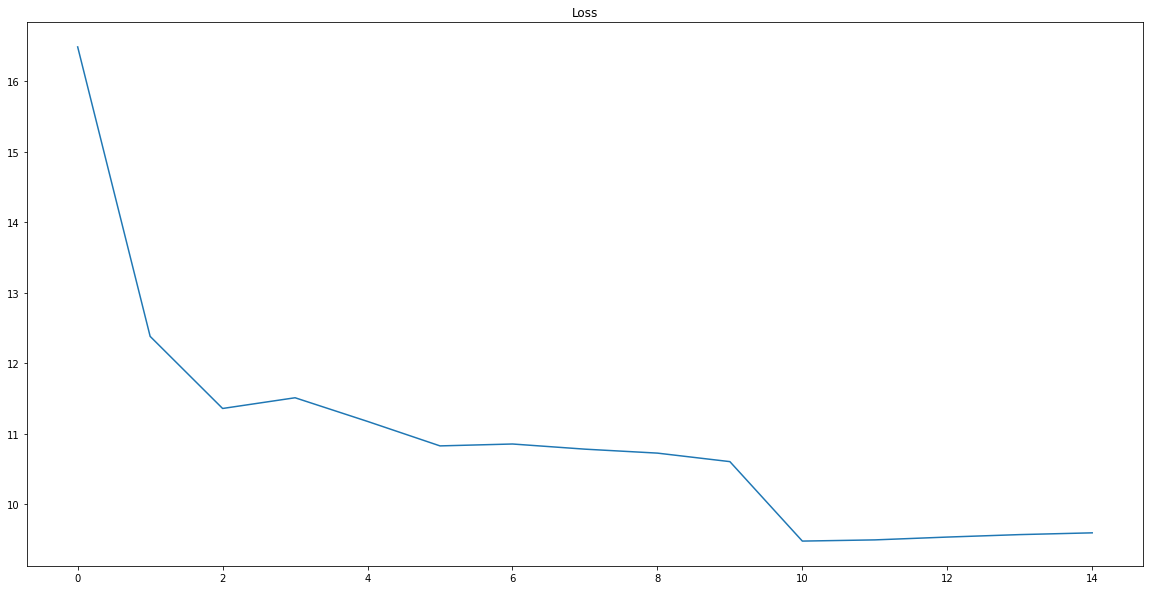

In [ ]:
plt.rcParams['figure.figsize'] = (20,10)
plt.title('Loss')
plt.plot(loss_plot)

In [ ]:
strat_lr = (1e-4) - ((1e-4) / 6.0 )*1
generator_optimizer = optim.Adam(itertools.chain(ecg_generator.parameters(), ppg_generator.parameters()),lr=strat_lr)
ppg_time_discriminator_optimizer = optim.Adam(ppg_time_discriminator.parameters(),lr=strat_lr)
ppg_freq_discriminator_optimizer = optim.Adam(ppg_freq_discriminator.parameters(),lr=strat_lr)
ecg_time_discriminator_optimizer = optim.Adam(ecg_time_discriminator.parameters(),lr=strat_lr)
ecg_freq_discriminator_optimizer = optim.Adam(ecg_freq_discriminator.parameters(),lr=strat_lr)

lr_decay = lambda epoch: (1e-4) - ((1e-4) / 6.0 )* (epoch+1)
generator_scheduler = optim.lr_scheduler.LambdaLR(optimizer=generator_optimizer, lr_lambda=lr_decay, verbose=False)
ecg_time_discriminator_scheduler = optim.lr_scheduler.LambdaLR(optimizer=ecg_time_discriminator_optimizer, lr_lambda=lr_decay, verbose=False)
ecg_freq_discriminator_scheduler = optim.lr_scheduler.LambdaLR(optimizer=ecg_freq_discriminator_optimizer, lr_lambda=lr_decay, verbose=False)
ppg_time_discriminator_scheduler = optim.lr_scheduler.LambdaLR(optimizer=ppg_time_discriminator_optimizer, lr_lambda=lr_decay, verbose=False)
ppg_freq_discriminator_scheduler = optim.lr_scheduler.LambdaLR(optimizer=ppg_freq_discriminator_optimizer, lr_lambda=lr_decay, verbose=False)

In [ ]:
for e in range(5):
  #train
  tqdm_dataset = tqdm(enumerate(train_loader))
  total_loss = 0
  for i,batch in tqdm_dataset:
    ppg,ecg = batch

    g_l,e_t_l,e_f_l,p_t_l,p_f_l = train(ppg,ecg,3,1,30,True)
    total_loss += g_l+e_t_l+e_f_l+p_t_l+p_f_l
    batch_loss = g_l+e_t_l+e_f_l+p_t_l+p_f_l
    tqdm_dataset.set_postfix({
        'Epoch':e+1,
        'Loss': '%.6f'%batch_loss.item(),
        'Total Loss': '%.6f'%(total_loss/(i+1)),
        'Generator Loss':'%.6f'%(g_l),
        'ECG Time Discriminator Loss':'%.6f'%(e_t_l),
        'ECG Freq Discriminator Loss':'%.6f'%(e_f_l),
        'PPG Time Discriminator Loss':'%.6f'%(p_t_l),
        'PPG Freq Discriminator Loss':'%.6f'%(p_f_l)
    })

  loss_plot.append(total_loss/(i+1))
  generator_scheduler.step()
  ecg_time_discriminator_scheduler.step()
  ecg_freq_discriminator_scheduler.step()
  ppg_time_discriminator_scheduler.step()
  ppg_freq_discriminator_scheduler.step()

  np.save('/gdrive/My Drive/model/cardiogan_loss2.npy',loss_plot)
  torch.save(ppg_generator,'/gdrive/My Drive/model/ppg_generator2.pkl')
  torch.save(ecg_generator,'/gdrive/My Drive/model/ecg_generator2.pkl')

  torch.save(ecg_time_discriminator,'/gdrive/My Drive/model/ecg_time_discriminator2.pkl')
  torch.save(ecg_freq_discriminator,'/gdrive/My Drive/model/ecg_freq_discriminator2.pkl')
  torch.save(ppg_time_discriminator,'/gdrive/My Drive/model/ppg_time_discriminator2.pkl')
  torch.save(ppg_freq_discriminator,'/gdrive/My Drive/model/ppg_freq_discriminator2.pkl')
  torch.save(ecg_fake_buffer,'/gdrive/My Drive/model/ecg_fake_buffer2.pkl')
  torch.save(ppg_fake_buffer,'/gdrive/My Drive/model/ppg_fake_buffer2.pkl')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
224it [1:20:11, 21.47s/it, Epoch=1, Loss=9.192776, Total Loss=9.383607, Generator Loss=9.072230, ECG Time Discriminator Loss=0.016574, ECG Freq Discriminator Loss=0.001346, PPG Time Discriminator Loss=0.101981, PPG Freq Discriminator Loss=0.000644]

torch.Size([1, 1, 1, 512])


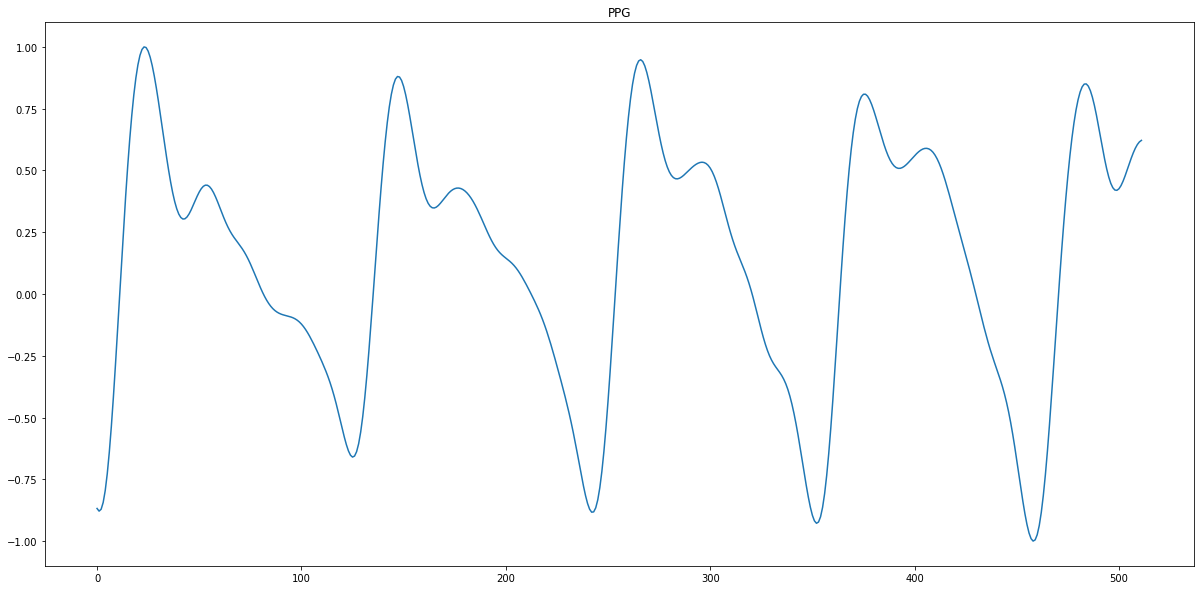

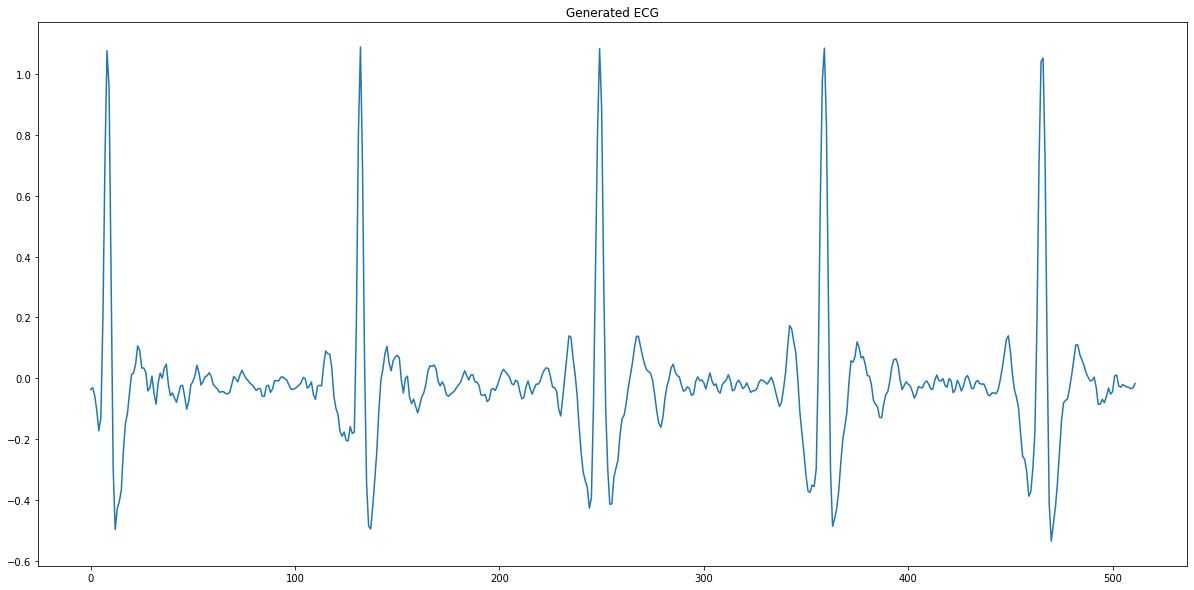

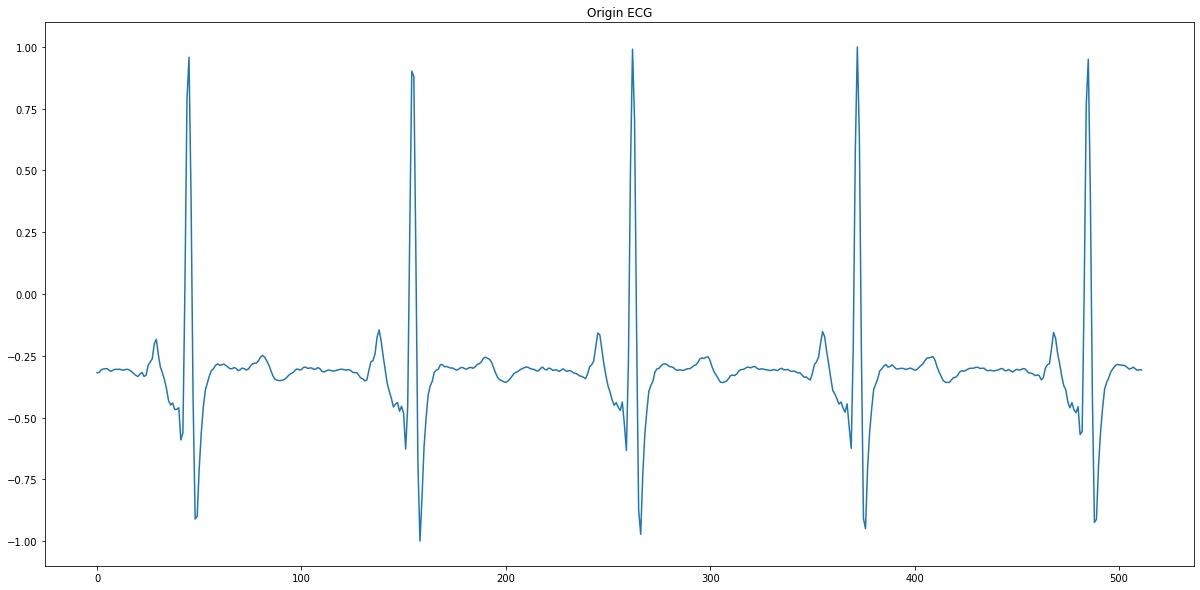

In [ ]:
plt.rcParams['figure.figsize'] = (70,10)

with torch.no_grad():
  ecg_generator.eval()

  ppg,ecg = test_data[12]#12,25,30
  ppg = torch.tensor(ppg)
  ppg.unsqueeze_(1)
  ppg.unsqueeze_(1)
  print(ppg.shape)

  ppg = Variable(ppg).cuda()
  generated_ecg = ecg_generator(ppg)
  generated_ecg.squeeze_()
  generated_ecg = generated_ecg.cpu()
  generated_ecg = filter_ecg(generated_ecg,128)

  
  plt.subplot(1,3,1)
  ppg.squeeze_(1)
  ppg.squeeze_(1)
  ppg.squeeze_(0)
  plt.title('PPG')
  plt.plot(ppg.cpu().detach())
  plt.show()
  plt.subplot(1,2,2)
  test = ecg_fake_buffer.data[0]
  plt.subplot(1,3,2)
  plt.title('Generated ECG')
  plt.plot(generated_ecg)
  plt.show()
  plt.subplot(1,3,3)
  plt.title('Origin ECG')
  plt.plot(ecg[0])
  plt.show()